# Dogs vs. Catsを畳み込みニューラルネットワークで解く

## パッケージ群のインポート

In [14]:
import tensorflow
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
a = np.ones((2,1))
b = np.ones((2,))
a + 1

array([[2.],
       [2.]])

In [2]:
import os, cv2, random
import numpy as np
import pandas as pd

In [3]:
from matplotlib import ticker
import seaborn as sns

## トレーニング・テストデータの作成

In [4]:
TRAIN_DIR = "./dogscats/train/"
TEST_DIR = "./dogscats/test/"

In [5]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [6]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]

In [7]:
train_images

['./dogscats/train/cat.0.jpg',
 './dogscats/train/cat.1.jpg',
 './dogscats/train/cat.10.jpg',
 './dogscats/train/cat.100.jpg',
 './dogscats/train/cat.1000.jpg',
 './dogscats/train/cat.10000.jpg',
 './dogscats/train/cat.10001.jpg',
 './dogscats/train/cat.10002.jpg',
 './dogscats/train/cat.10003.jpg',
 './dogscats/train/cat.10004.jpg',
 './dogscats/train/cat.10005.jpg',
 './dogscats/train/cat.10006.jpg',
 './dogscats/train/cat.10007.jpg',
 './dogscats/train/cat.10008.jpg',
 './dogscats/train/cat.10009.jpg',
 './dogscats/train/cat.1001.jpg',
 './dogscats/train/cat.10010.jpg',
 './dogscats/train/cat.10011.jpg',
 './dogscats/train/cat.10012.jpg',
 './dogscats/train/cat.10013.jpg',
 './dogscats/train/cat.10014.jpg',
 './dogscats/train/cat.10015.jpg',
 './dogscats/train/cat.10016.jpg',
 './dogscats/train/cat.10017.jpg',
 './dogscats/train/cat.10018.jpg',
 './dogscats/train/cat.10019.jpg',
 './dogscats/train/cat.1002.jpg',
 './dogscats/train/cat.10020.jpg',
 './dogscats/train/cat.10021.jpg',
 

In [8]:
len(train_images)

25000

In [9]:
train_images[1000]

'./dogscats/train/cat.10898.jpg'

### リストの内包表記

In [10]:
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]

In [11]:
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

In [12]:
len(train_dogs)

12500

In [13]:
len(train_cats)

12500

In [14]:
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [15]:
len(test_images)

12500

### リストのスライス処理

In [16]:
train_images = train_dogs[:1000] + train_cats[:1000]

In [17]:
len(train_images)

2000

In [18]:
random.shuffle(train_images)

In [19]:
test_images =  test_images[:25]

In [20]:
len(test_images)

25

### 画像ファイルを多次元配列に変換する

In [21]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [22]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T #transpose mxn > nxm
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
            
    return data
        

In [23]:
train = prep_data(train_images)
test = prep_data(test_images)

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 25


In [24]:
train.shape

(2000, 3, 64, 64)

In [25]:
test.shape

(25, 3, 64, 64)

### ラベル一覧をリスト型変数に格納しよう

In [26]:
labels = []
for i in train_images:
    if 'dog.' in i:
        labels.append(1)
    else:
        labels.append(0)

In [27]:
labels[0:10]

[1, 0, 1, 0, 1, 1, 1, 0, 0, 1]

In [28]:
train_images[0:10]

['./dogscats/train/dog.10814.jpg',
 './dogscats/train/cat.10513.jpg',
 './dogscats/train/dog.10196.jpg',
 './dogscats/train/cat.10649.jpg',
 './dogscats/train/dog.10258.jpg',
 './dogscats/train/dog.10808.jpg',
 './dogscats/train/dog.10036.jpg',
 './dogscats/train/cat.10766.jpg',
 './dogscats/train/cat.10460.jpg',
 './dogscats/train/dog.10356.jpg']

Text(0.5, 1.0, 'Cats and Dogs')

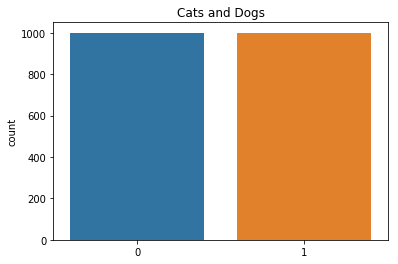

In [29]:
sns.countplot(labels)
plt.title('Cats and Dogs')

### 画像データの確認

In [30]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

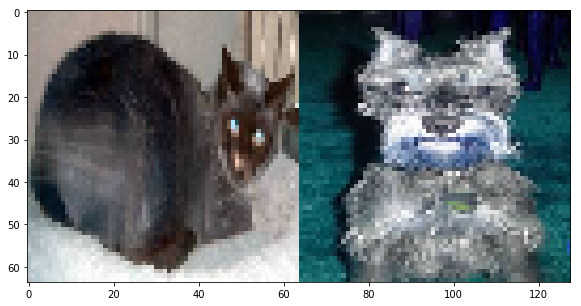

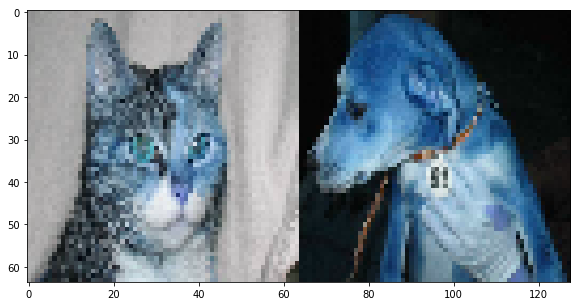

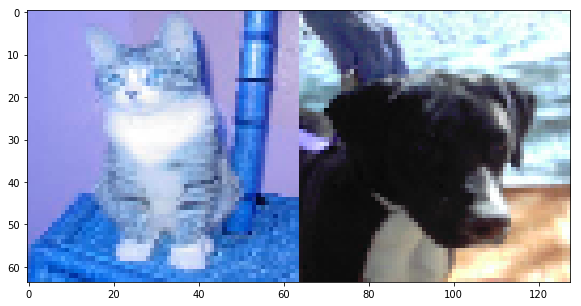

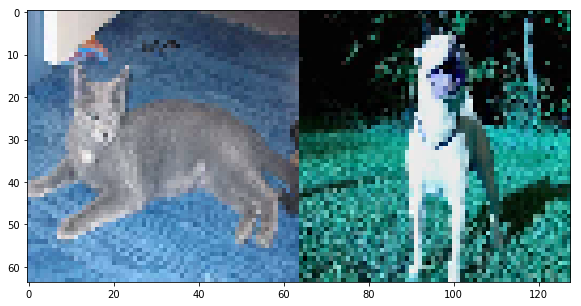

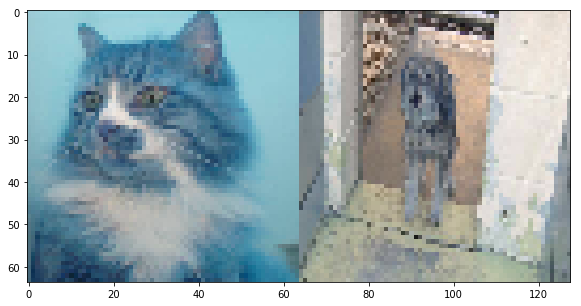

In [31]:
for idx in range(10,15):
    show_cats_and_dogs(idx)

### ピクセル値を平均して画像を生成する

Text(0.5, 1.0, 'Your Average Dog')

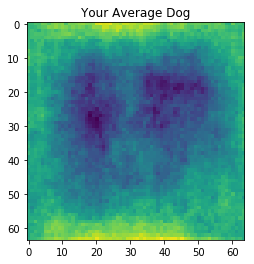

In [32]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title('Your Average Dog')


Text(0.5, 1.0, 'Your Average Cat')

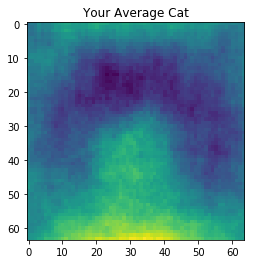

In [33]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Your Average Cat')

### CatdogNet-16 を定義しよう

In [34]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


In [35]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

def catdog():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = catdog()
    


### トレーニングを実行しよう

In [36]:
nb_epoch = 10
batch_size = 16

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# monitor: 監視対象
# patience: 訓練が停止し，値が改善しなくなってからのエポック数．
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()
# タプルで受け取る


### ロスをプロットしよう

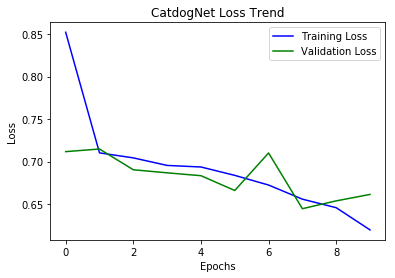

In [37]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('CatdogNet Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

### 推定結果を可視化しよう

I am 55.67% sure this is a Cat


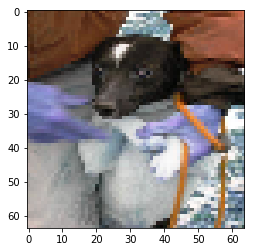

I am 64.66% sure this is a Cat


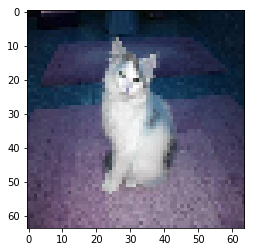

I am 68.66% sure this is a Cat


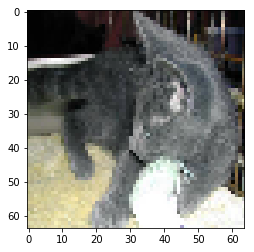

I am 74.33% sure this is a Dog


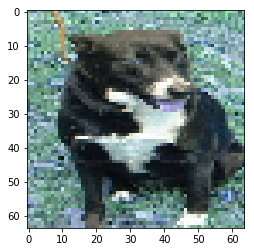

I am 70.39% sure this is a Dog


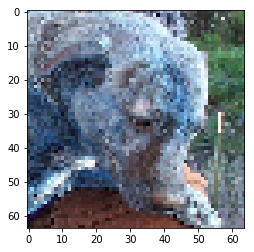

I am 68.02% sure this is a Dog


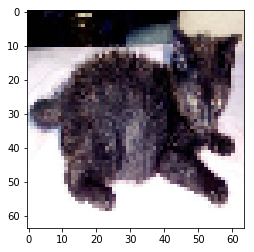

I am 52.37% sure this is a Dog


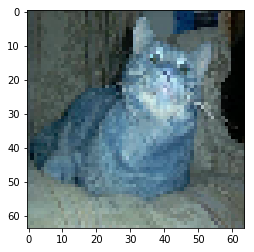

I am 77.71% sure this is a Dog


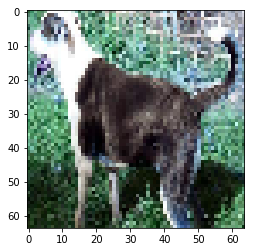

I am 61.19% sure this is a Dog


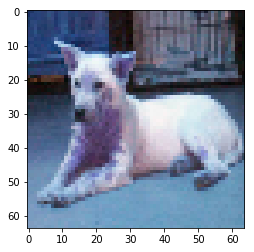

I am 52.39% sure this is a Cat


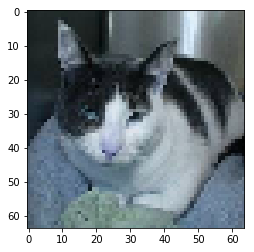

In [38]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5:
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else:
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()